In [ ]:
# Import necessary libraries

!pip install opencv-python --break-system-packages

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def read_ground_truth(file_path):
    import re  # Regular expressions for parsing

    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    for line in lines:
        if line.startswith("#"):
            continue

        # Adjust regex to allow negative coordinates
        match = re.match(
            r"(\S+)\s*/\s*(\d+)\s+(-?\d+)\s+(-?\d+)\s+(-?\d+)\s+(-?\d+)\s+(\d+)\s+'([^']+)'\s+'([^']+)'",
            line.strip()
        )

        if not match:
            print(f"Malformed line skipped: {line.strip()}")
            continue

        # Extract matched groups
        timestamp = match.group(1)
        frame_index = int(match.group(2))
        x1, y1, x2, y2 = map(int, match.group(3, 4, 5, 6))
        object_id = int(match.group(7))
        obj_type = match.group(8)
        subtype = match.group(9)

        data.append({
            "timestamp": timestamp,
            "frame_index": frame_index,
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2,
            "object_id": object_id,
            "type": obj_type,
            "subtype": subtype
        })

    return pd.DataFrame(data)

# Function to load image by frame index
def load_image_by_frame(dataset_folder, frame_index):
    # Adjust to use 5-digit naming convention
    image_path = os.path.join(dataset_folder, f"frame_{frame_index:06d}.jpg")
    if os.path.exists(image_path):
        return cv2.imread(image_path)
    else:
        print(f"Image not found: {image_path}")
        return None


# Function to visualize ground truth bounding boxes on an image
def visualize_ground_truth(image, bbox, label):
    x1, y1, x2, y2 = bbox
    color = (0, 255, 0)  # Green for bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image


def extract_traffic_light_images(dataset_folder, ground_truth):
    images = []
    labels = []
    label_map = {"go": 0, "stop": 1, "warning": 2, "ambiguous": 3}  # Map subtypes to numeric labels

    for _, row in tqdm(ground_truth.iterrows()):
        frame_index = row["frame_index"]
        image = load_image_by_frame(dataset_folder, frame_index)
        if image is not None:
            # Validate and adjust bounding box coordinates
            img_height, img_width, _ = image.shape
            x1, y1 = max(0, row["x1"]), max(0, row["y1"])
            x2, y2 = min(img_width, row["x2"]), min(img_height, row["y2"])

            if x1 >= x2 or y1 >= y2:
                print(f"Skipping invalid bounding box: {x1, y1, x2, y2} in frame {frame_index}")
                continue

            # Crop and resize the region of interest (ROI)
            cropped_img = image[y1:y2, x1:x2]  # Crop the ROI
            cropped_img = cv2.resize(cropped_img, (64, 64)) / 255.0  # Resize and normalize
            images.append(cropped_img)

            # Add the corresponding label
            labels.append(label_map[row["subtype"]])  # Use subtype as the label
    return np.array(images), np.array(labels)


# Main processing logic
if __name__ == "__main__":
    print("data preprocessing on LaRA dataset")
    # Path to ground truth file
    ground_truth_path = "/Users/carl/Documents/GitHub/smtThrottle/traffic_light_recognition/dataset/Lara_UrbanSeq1_GroundTruth_GT.txt"
    print("reading ground truth txt")
    ground_truth = read_ground_truth(ground_truth_path)
    # print(ground_truth.head())

    # Path to dataset folder
    dataset_folder = "/Users/carl/Documents/GitHub/smtThrottle/traffic_light_recognition/dataset/Lara3D_UrbanSeq1_JPG/"

    print("read dataset images")
    # Extract and prepare dataset
    images, labels = extract_traffic_light_images(dataset_folder, ground_truth)
    print(f"Dataset size: {len(images)} images")

    # split into train test split and save dataset
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    print(f"Training set size: {len(x_train)} images")
    print(f"Testing set size: {len(x_test)} images")

    # save dataset
    np.save("x_train.npy", x_train)
    np.save("x_test.npy", x_test)
    np.save("y_train.npy", y_train)
    np.save("y_test.npy", y_test)
    print("dataset saved")


ModuleNotFoundError: No module named 'cv2'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# cnn model to train
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from datetime import datetime

# load the god damn model from the npy files because we're now on google colab
x_train = np.load("/content/drive/My Drive/traffic_light_recognition/x_train.npy")  # Training images
x_test = np.load("/content/drive/My Drive/traffic_light_recognition/x_test.npy")    # Testing images
y_train = np.load("/content/drive/My Drive/traffic_light_recognition/y_train.npy")  # Training labels
y_test = np.load("/content/drive/My Drive/traffic_light_recognition/y_test.npy")

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes: "go", "stop", "warning", "ambiguous"
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Format the current timestamp into a safe string
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the model with the timestamp in the filename
model.save(f"/content/drive/My Drive/traffic_light_recognition/output/output_{timestamp}.h5")

print(f"Model saved as output_{timestamp}.h5")
print("training done, model saved")


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.9191 - loss: 0.2079 - val_accuracy: 0.9902 - val_loss: 0.0315
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9905 - loss: 0.0306 - val_accuracy: 0.9924 - val_loss: 0.0291
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.9898 - loss: 0.0310 - val_accuracy: 0.9853 - val_loss: 0.0376
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.9927 - loss: 0.0223 - val_accuracy: 0.9869 - val_loss: 0.0374
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.9941 - loss: 0.0194 - val_accuracy: 0.9973 - val_loss: 0.0127
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9956 - val_loss: 0.0147
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.9948 - loss: 0.0175 - val_accuracy: 0.9978 - val_loss: 0.0109
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.9981 - loss: 0

Model saved as output_20250114_003701.h5
training done, model saved


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Test Loss: 0.0193
Test Accuracy: 0.9951
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       697
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00        16
           3       1.00      0.89      0.94        83

    accuracy                           1.00      1834
   macro avg       1.00      0.97      0.98      1834
weighted avg       1.00      1.00      0.99      1834



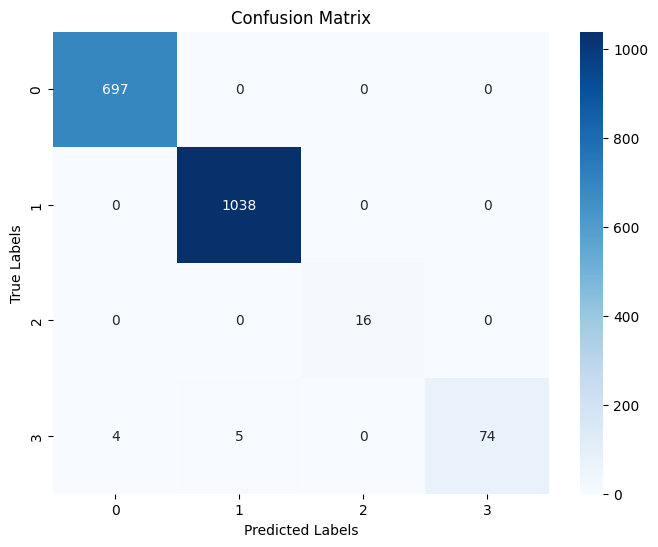

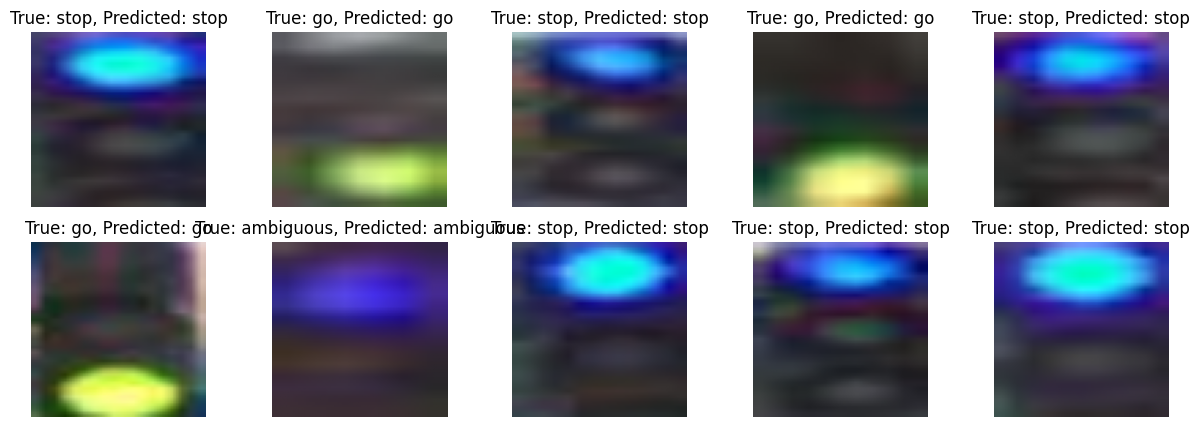

In [17]:

import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random


def to_category(key):
    if key == 0:
        return "go"
    elif key == 1:
        return "stop"
    elif key == 2:
        return "warning"
    elif key == 3:
        return "ambiguous"

# Load the saved model
model_path = "/content/drive/My Drive/traffic_light_recognition/output/output_20250114_003701.h5"
model = tf.keras.models.load_model(model_path)

# Load the test data
x_test = np.load("/content/drive/My Drive/traffic_light_recognition/x_test.npy")
y_test = np.load("/content/drive/My Drive/traffic_light_recognition/y_test.npy")

# Make predictions
y_pred = np.argmax(model.predict(x_test), axis=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate and print the classification report
print(classification_report(y_test, y_pred))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# pick out some test images
num_images = 10

grid_cols = 5
grid_rows = 2
disp_indicies = random.sample(range(len(x_test)), num_images)

plt.figure(figsize=(15, 5))
for i, index in enumerate(disp_indicies):
    plt.subplot(grid_rows, grid_cols, i + 1)
    plt.imshow(x_test[index])
    plt.title(f"True: {to_category(y_test[index])}, Predicted: {to_category(y_pred[index])}")
    plt.axis('off')

plt.show()
